In [9]:
from shared.preface import *
import shared.functions as fct

# ------------------------------------- #
# Select halo to do gravity tests with. #
# ------------------------------------- #

sim = 'L012N376'
snap = '0036'
z = 0 
mass_gauge = 12.5  # in log10 Msun
mass_range = 0.1

hname = f'1e+{mass_gauge}_pm{mass_range}Msun_Test'
fct.halo_batch_indices(sim, snap, mass_gauge, mass_range, 'halos', 5, hname)
halo_batch_IDs = np.load(f'{sim}/halo_batch_{hname}_indices.npy')
halo_batch_params = np.load(f'{sim}/halo_batch_{hname}_params.npy')
halo_num = len(halo_batch_params)

print('Halo batch params (Rvir,Mvir,cNFW):')
print(halo_batch_params)

halo_j = 0
halo_ID = halo_batch_IDs[halo_j]
print(halo_ID)

halo_rvir = halo_batch_params[halo_j, 0]
halo_Mvir = halo_batch_params[halo_j, 1]
halo_cNFW = halo_batch_params[halo_j, 2]

halo_rvir *= kpc
print(f'{halo_Mvir:.2e}')
halo_Mvir = 10**halo_Mvir * Msun
print(f'{halo_Mvir/Msun:.2e}')
halo_rho0 = fct.scale_density_NFW(z, halo_cNFW)
halo_Rs = halo_rvir / halo_cNFW


# --------------------------- #
# Read and load DM positions. #
# --------------------------- #

IDname = f'origID{halo_ID}_snap_{snap}_Test'
fct.read_DM_halo_index(sim, snap, halo_ID, IDname)
DM_raw = np.load(f'{sim}/DM_pos_{IDname}.npy')  

print(len(DM_raw))

# ---------------------- #
# Cell division process. #
# ---------------------- #

# Initialize grid.
GRID_L = (int(np.abs(DM_raw).max()) + 1)*kpc
raw_grid = fct.grid_3D(GRID_L, GRID_L)  # to get 8 all-covering cells
init_grid = np.expand_dims(raw_grid, axis=1)

# Prepare arrays for cell division.
DM_raw *= kpc
DM_pos = np.expand_dims(DM_raw, axis=0)
DM_pos_for_cell_division = np.repeat(DM_pos, len(init_grid), axis=0)

# Cell division.
DM_lim = 10000
cell_division_count = fct.cell_division(
    init_grid, DM_pos_for_cell_division, GRID_L, DM_lim, None, 
    sim, IDname
)

# Load files from cell division.
fin_grid = np.load(f'{sim}/fin_grid_{IDname}.npy')
DM_count = np.load(f'{sim}/DM_count_{IDname}.npy')
cell_com = np.load(f'{sim}/cell_com_{IDname}.npy')
cell_gen = np.load(f'{sim}/cell_gen_{IDname}.npy')

print(fin_grid.shape)

Halo batch params (Rvir,Mvir,cNFW):
[[329.17613982  12.58066253   8.41010098]
 [298.72978142  12.45421305  10.25293176]]
1
1.26e+01
3.81e+12
2725583


In [3]:
print(fin_grid.shape, DM_count.shape, cell_com.shape, cell_gen.shape)
print(DM_count.sum() - len(DM_raw))
# note: 1 DM particle is "missing" in grid
print(f'snapshot {snap} : cell division rounds: {cell_division_count}')
print(f'Smalles cell length: {GRID_L/(2**cell_division_count)/kpc} kpc')

(1051, 1, 3) (1051,) (1051, 3) (1051,)
-1
snapshot 0036 : cell division rounds: 6
Smalles cell length: 3.125 kpc


In [4]:
# --------------------------------------------- #
# Calculate gravity grid (in batches of cells). #
# --------------------------------------------- #

batch_size = 50
bs_cc = chunks(batch_size, fin_grid)
bs_count = chunks(batch_size, DM_count)
bs_com = chunks(batch_size, cell_com)
bs_gen = chunks(batch_size, cell_gen)

b_nums = []
for b, (b_cc,  b_gen,  b_com,  b_count) in enumerate(
    zip(bs_cc, bs_gen, bs_com, bs_count)
):
    b_nums.append(b)
    b_cc = np.array(b_cc)
    b_gen = np.array(b_gen)
    b_com = np.array(b_com)
    b_count = np.array(b_count)

    # Calculate gravity in each cell in current batch.
    b_DM = np.repeat(DM_pos, len(b_cc), axis=0)
    bname = f'batch{b}'
    fct.cell_gravity(
        b_cc, b_com, b_gen, GRID_L,
        b_DM, b_count, DM_lim,
        sim, bname, long_range=True
    )
bs_nums = np.array(b_nums)

# Combine and then delete batch files.
dPsi_batches = [
    np.load(f'{sim}/Test_dPsi_grid_batch{b}.npy') for b in bs_nums
]
dPsi_fin = np.array(list(chain.from_iterable(dPsi_batches)))
np.save(f'{sim}/dPsi_grid_{IDname}.npy', dPsi_fin)

# Delete intermediate data.
fct.delete_temp_data(f'{sim}/Test_dPsi_*batch*.npy') 
# fct.delete_temp_data(f'{sim}/DM_pos_*.npy')

(1051, 3) (1051, 1, 3)
[2.54124848e-32 3.61124784e-32 3.61124784e-32 3.61124784e-32
 3.61124784e-32] [5.61724607e-35 1.44572384e-34 1.31085817e-34 1.24235612e-33
 2.02422568e-34]


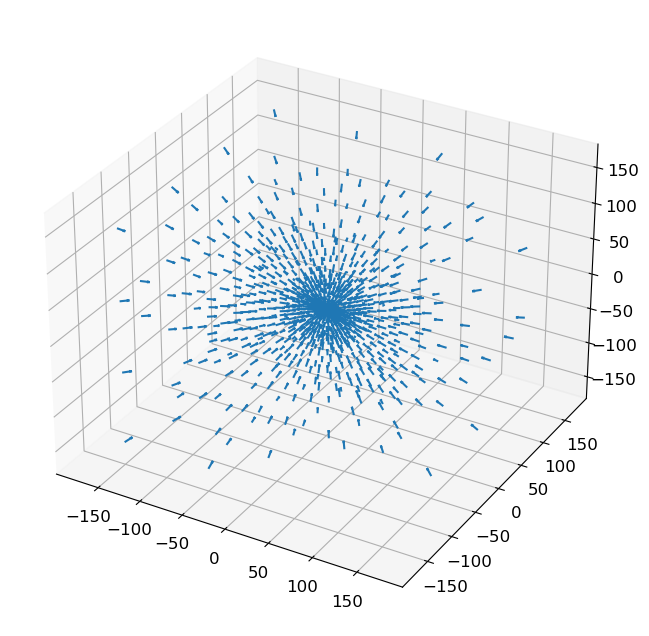

In [5]:
# %matplotlib widget
%matplotlib inline

dPsi_test = np.load(f'{sim}/dPsi_grid_{IDname}.npy')/(kpc/s**2)
fin_grid = np.load(f'{sim}/fin_grid_{IDname}.npy')
print(dPsi_test.shape, fin_grid.shape)

adapted_grid = np.squeeze(fin_grid, axis=1)

NFW_grav = np.array([
    fct.dPsi_dxi_NFW(x_i, 0., halo_rho0, halo_Mvir, halo_rvir, halo_Rs, 'HALO')
    for x_i in adapted_grid
])/(kpc/s**2)
NFW_mags = np.sqrt(np.sum(NFW_grav**2, axis=1))

pos_grid = adapted_grid/kpc
xGrid = pos_grid[:,0]
yGrid = pos_grid[:,1]
zGrid = pos_grid[:,2]

xPsi = dPsi_test[:,0]
yPsi = dPsi_test[:,1]
zPsi = dPsi_test[:,2]
rPsi = np.sqrt(np.sum(dPsi_test**2, axis=1))

# print(NFW_mags[-5:], rPsi[-5:])
print(NFW_mags[:5], rPsi[:5])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

start, stop = 0, -1 
ax.quiver(
    xGrid[start:stop], yGrid[start:stop], zGrid[start:stop], 
    xPsi[start:stop], yPsi[start:stop], zPsi[start:stop], 
    length=10, normalize=True
)

plt.show()

In [6]:
# Sort cells by distance from center (0,0,0).
grid_dis = np.sqrt(np.sum(pos_grid**2, axis=1))
dis_ind = grid_dis.argsort()

grid_dis = grid_dis[dis_ind]
rPsi = rPsi[dis_ind]
NFW_mags = NFW_mags[dis_ind]

dPsi/NFW: min=0.0, max=13.50771100619166


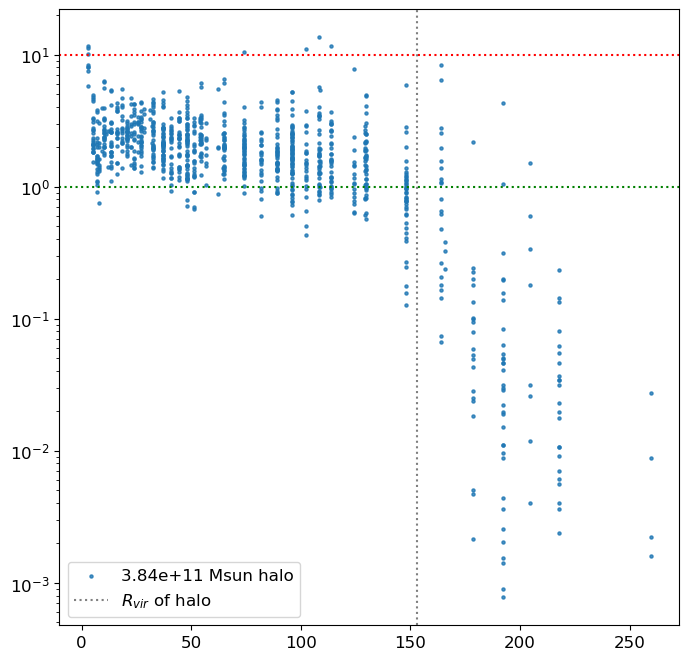

In [7]:
grav_ratio = rPsi/NFW_mags
print(f'dPsi/NFW: min={np.min(grav_ratio)}, max={np.max(grav_ratio)}')


fig, ax = plt.subplots(1,1)

ax.scatter(
    grid_dis, grav_ratio, s=5, alpha=0.8, label=f'{halo_Mvir/Msun:.2e} Msun halo'
)
ax.axhline(1, c='green', ls=':')
ax.axhline(10, c='red', ls=':')
ax.axhline(np.min(grav_ratio), c='red', ls=':')
ax.axvline(
    halo_rvir/kpc, c='black', ls=':', alpha=0.5, label=r'$R_{vir}$ of halo'
)

ax.set_yscale('log')
plt.legend()
plt.show()

## Test if halo mass is correct in each snapshot.

In [8]:
sim = 'L012N376'

for snap in NUMS_SNAPSHOTS[::-1]:
    print(snap)
    fname = f'origID27_snap_{snap}'
    DM_count = np.load(f'{sim}/DM_count_{fname}.npy')
    Mvir = 10**11.14465103*Msun
    print(f'{Mvir/Msun:.2e}')
    Mtot = np.sum(DM_count)*DM_SIM_MASS
    print(f'{(Mtot-Mvir)/Msun:.2e}')

0036
1.40e+11
5.20e+09
0035
1.40e+11
2.70e+09
0034
1.40e+11
-2.47e+09
0033
1.40e+11
-3.75e+09
0032
1.40e+11
-8.06e+09
0031
1.40e+11
-1.08e+10
0030
1.40e+11
-1.61e+10
0029
1.40e+11
-2.00e+10
0028
1.40e+11
-2.36e+10
0027
1.40e+11
-2.74e+10
0026
1.40e+11
-2.94e+10
0025
1.40e+11
-3.75e+10
0024
1.40e+11
-4.35e+10
0023
1.40e+11
-4.74e+10
0022
1.40e+11
-7.49e+10
0021
1.40e+11
-8.76e+10
0020
1.40e+11
-9.65e+10
0019
1.40e+11
-9.91e+10
0018
1.40e+11
-1.02e+11
0017
1.40e+11
-1.05e+11
0016
1.40e+11
-1.07e+11
0015
1.40e+11
-1.06e+11
0014
1.40e+11
-1.13e+11
0013
1.40e+11
-1.24e+11
